## For Colabs

In [42]:
from getpass import getpass
import os

user = "OliverJBoom"
password = getpass('github password')

os.environ['GITHUB_AUTH'] = user + ':' + password
os.chdir("/content")
!rm -rf "/content/acse-9-independent-research-project-OliverJBoom"
!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-9-independent-research-project-OliverJBoom.git
os.chdir("acse-9-independent-research-project-OliverJBoom/Src")

github password··········
Cloning into 'acse-9-independent-research-project-OliverJBoom'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 543 (delta 62), reused 51 (delta 22), pack-reused 446
Receiving objects: 100% (543/543), 9.03 MiB | 24.93 MiB/s, done.
Resolving deltas: 100% (300/300), done.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive/", force_remount=True)
path = "/content/gdrive/My Drive/Chai/Data"

Mounted at /content/gdrive/


## Loading Packages

In [18]:
from deeplearning import *
from models import *
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import pickle
from preprocessing import *
from statistics import median
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from utils import *
import warnings

warnings.filterwarnings("ignore")

set_seed(42)

True

### Insuring that training is done on GPU if available

In [89]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


## Loading Data

In [134]:
path = "Data/Commodity_Data/"
universe_dict = universe_select(path, "MTL")
use_lg_returns = False
use_PCA = False

## Preprocessing

In [135]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)

# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)

# Making sure that all the points in the window have consistent length
universe_dict = truncate_window_length(universe_dict)

# # Generating the dataset
if use_lg_returns:
    # Lg Returns Only
    df_full = generate_dataset(universe_dict, lg_returns_only=True, price_only=False)
    target_col = ["cu_lme", "al_lme", "sn_lme", "pb_lme", "ni_lme"]
    
else:
    # Price Only
    df_full = generate_dataset(universe_dict, lg_returns_only=False, price_only=True)
    target_col = ["price_cu_lme", "price_al_lme", "price_sn_lme", "price_pb_lme", "price_ni_lme"]

# Set to False initially
PCA_used = False

Included Instrument:
al_shfe
al_lme
al_comex_p
Rows removed: 1
al_comex_s
al_lme_s
yuan
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci
sn_lme
pb_lme
ni_lme


In [136]:
# Visualise the plots
# visualise_universe(universe_dict)

In [137]:
df_full = df_full[target_col]
df_full.head(15)
# df_full.tail(5)

price_cu_lme  price_al_lme  price_sn_lme  price_pb_lme  \
date                                                                 
2014-06-04        6834.0       1812.75       23225.0        2103.0   
2014-06-05        6803.0       1824.25       23245.0        2109.0   
2014-06-06        6696.0       1856.75       23195.0        2109.0   
2014-06-09        6688.5       1886.00       23295.0        2141.0   
2014-06-10        6710.0       1865.50       22865.0        2140.0   
2014-06-11        6743.0       1827.00       22850.0        2125.0   
2014-06-12        6643.5       1803.75       22575.0        2075.0   
2014-06-13        6679.5       1803.75       22605.0        2086.0   
2014-06-16        6718.5       1809.25       22450.0        2106.0   
2014-06-17        6721.5       1807.75       22550.0        2118.0   
2014-06-18        6713.5       1833.25       22600.0        2124.0   
2014-06-19        6736.5       1850.00       22600.0        2129.0   
2014-06-20        6840.5       1847.75       22575.0        2130.0   
2014-06-23        6917.0       1852.25       22550.0        2177.0   
2014-06-24        6918.5       1862.75       22575.0        2183.0   

            price_ni_lme  
date                      
2014-06-04       19025.0  
2014-06-05       19030.0  
2014-06-06       18875.0  
2014-06-09       18905.0  
2014-06-10       18775.0  
2014-06-11       18305.0  
2014-06-12       18000.0  
2014-06-13       18070.0  
2014-06-16       18650.0  
2014-06-17       19120.0  
2014-06-18       18740.0  
2014-06-19       18550.0  
2014-06-20       18400.0  
2014-06-23       18425.0  
2014-06-24       18130.0

### Normalizing the dataset

In [138]:
# Forecast length
# forecast_length = 5
# forecast_length = 22
# forecast_length = 66
forecast_length = 132

# Data scaling
scaler_data_X = MinMaxScaler()
scaler_data_y = MinMaxScaler()

df_target = df_full[target_col]

data_X = scaler_data_X.fit_transform(df_full)[:-forecast_length, :]
# Need to have an independent scaler for inverse_transforming later
data_y = scaler_data_y.fit_transform(df_target)

# Offset target one forecast length
data_y = data_y[forecast_length:, :]

### PCA

In [139]:
# Reducing the dataset to containing a threshold amount of variance
if use_PCA:
    n_dim = dimension_selector(data_X, thresh=0.95)
    data_X = dimension_reduce(data_X, n_dim)

print("data_X ", data_X.shape, "data_y ", data_y.shape)

data_X  (1183, 5) data_y  (1183, 5)


### Slicing Series into Windows

In [140]:
# The input size of each time series window
series_length = 132
  
data_X, data_y = slice_series(data_X, data_y, series_length, dataset_pct=1.0)
print("data_X ", data_X.shape, "data_y ", data_y.shape)

data_X  (1051, 132, 5) data_y  (1051, 5)


### Hyperparameters

In [145]:
# Hyperparameters
learning_rate = 1e-2
momentum = 0.5
weight_decay = 0

# Batch Parameters
batch_size = 32

# Training Parameters
n_epochs = 20000
patience = 60
disp_freq= 10
fig_disp_freq= 10

# Model Parameters
num_features = data_X.shape[2]
hidden_dim = 8
dense_hidden = 32
num_layers = 1
output_dim = data_y.shape[1]
dropout = 0

### Initialising the model

In [146]:
model = LSTM(num_features=num_features, 
             hidden_dim=hidden_dim,
             dense_hidden=dense_hidden,
             series_length = series_length,
             batch_size=batch_size,
             output_dim=output_dim, 
             num_layers=num_layers, 
             device=device,
             dropout=dropout)

model.to(device)

print("num_features %i \nhidden_dim %i\nseries_length %i \nbatch_size %i\noutput_dim %i \nnum_layers %i"
      % (num_features, hidden_dim, series_length, batch_size,output_dim, num_layers))

print('data_X ', data_X.shape, '\ndata_y', data_y.shape)

num_features 5 
hidden_dim 8
series_length 132 
batch_size 32
output_dim 5 
num_layers 1
data_X  (1051, 132, 5) 
data_y (1051, 5)


In [147]:
# Loading trained model
# model = torch.load("/content/gdrive/My Drive/Chai/Models/Pths/" + "partial_dataset_LSTM_0_1206.pth")
# model.to(device)

Epoch: 0 Train: 5.32866 Val: 4.61039  Time: 1.500  Best Val: 4.61039


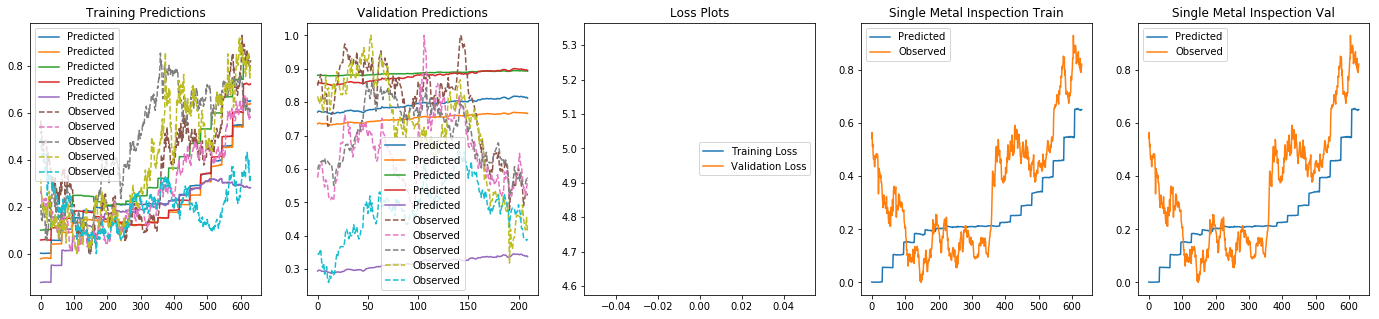

Epoch: 10 Train: 3.32574 Val: 6.60715  Time: 16.875  Best Val: 3.79028


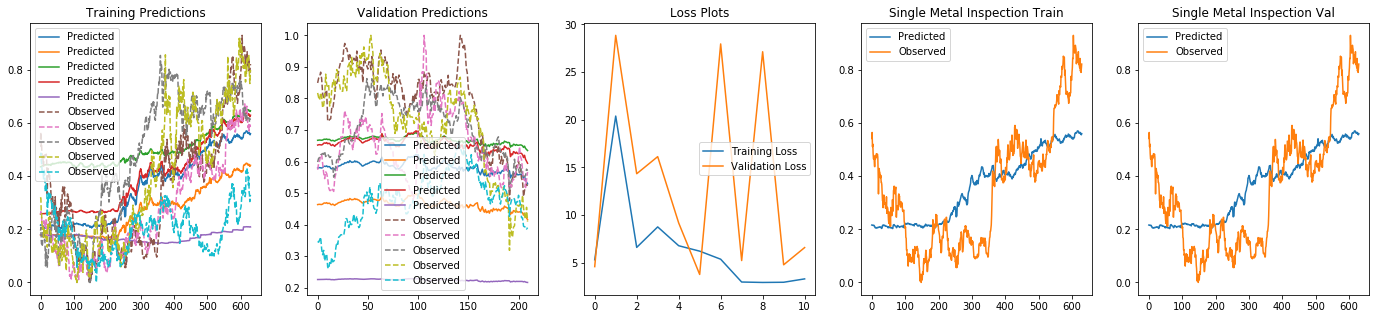

Epoch: 20 Train: 2.03251 Val: 4.87279  Time: 32.407  Best Val: 3.79028


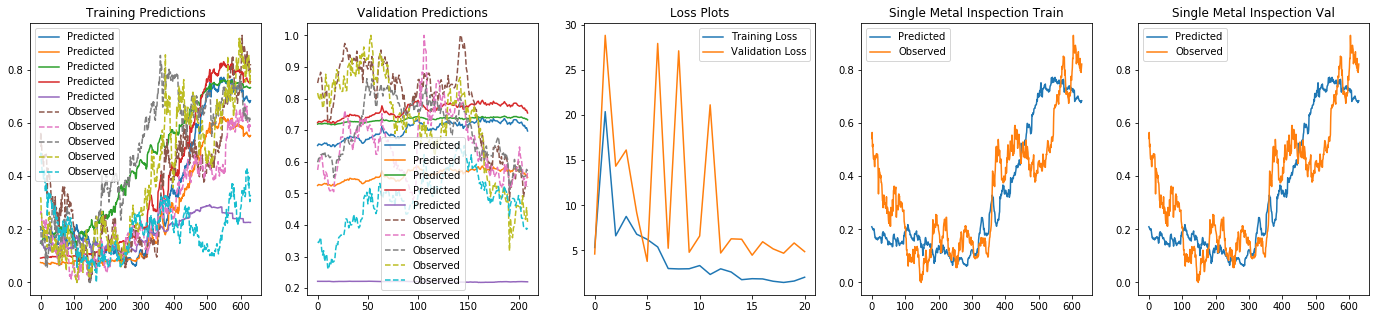

Epoch: 30 Train: 1.49018 Val: 4.51883  Time: 47.901  Best Val: 3.79028


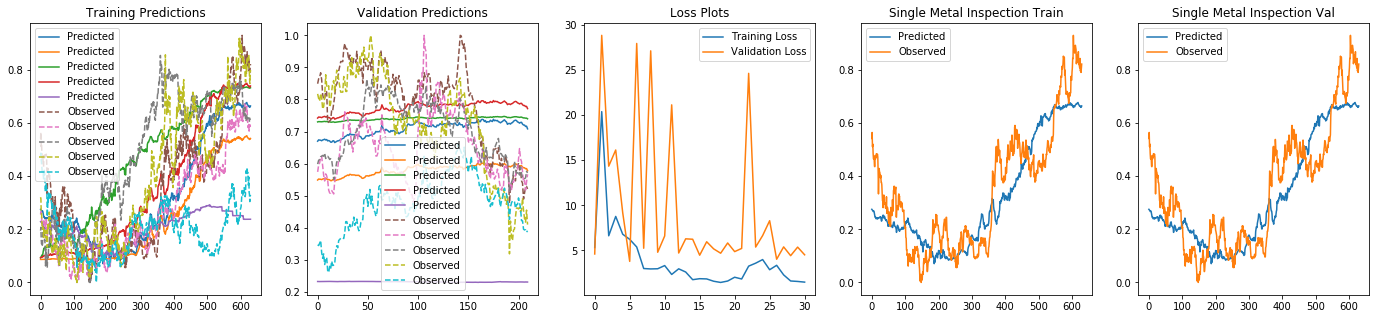

Epoch: 40 Train: 1.63546 Val: 4.89188  Time: 63.357  Best Val: 3.79028


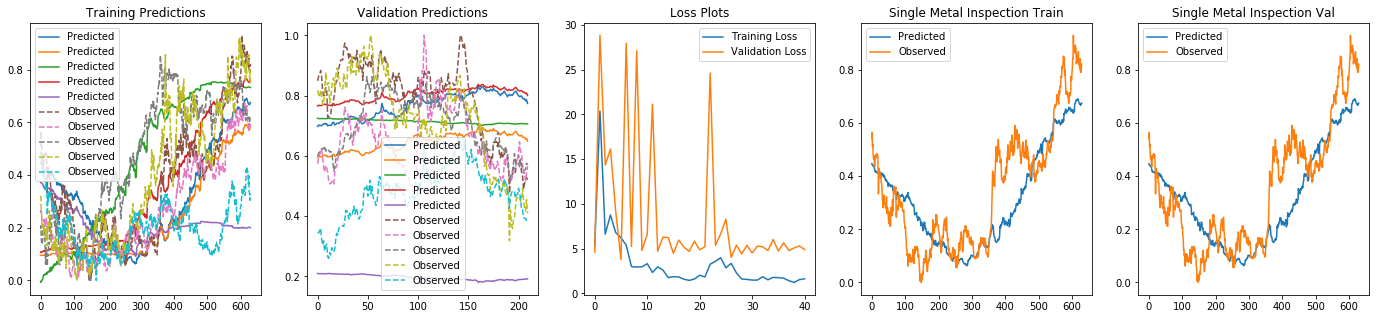

Epoch: 50 Train: 2.13026 Val: 5.73471  Time: 78.869  Best Val: 3.79028


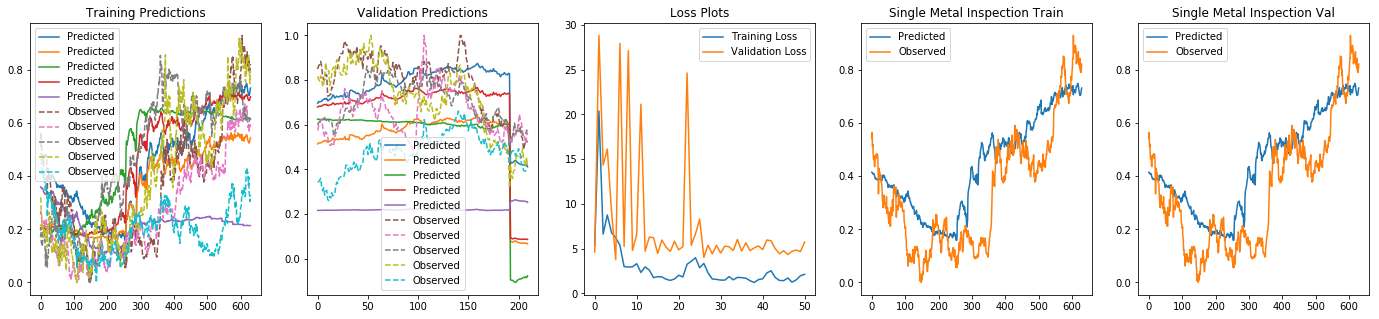

Epoch: 60 Train: 3.35069 Val: 18.89656  Time: 94.380  Best Val: 3.38892


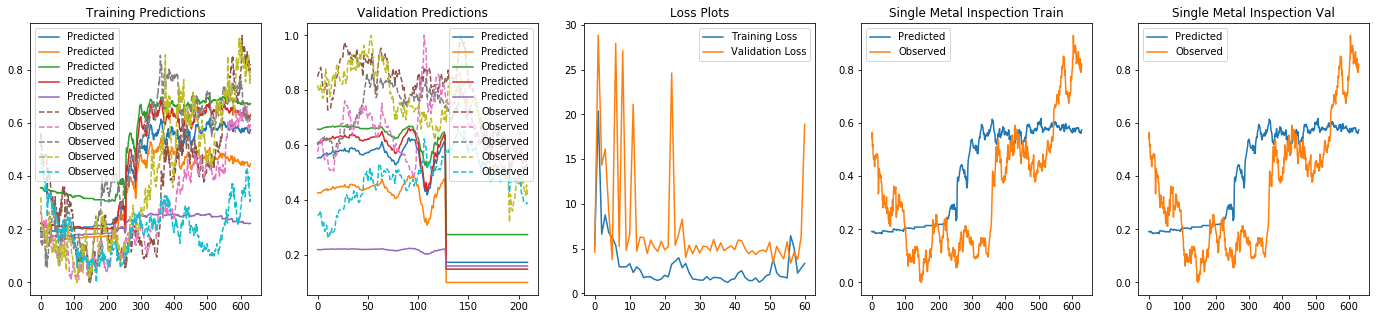

Epoch: 70 Train: 2.57800 Val: 4.01280  Time: 109.942  Best Val: 3.38892


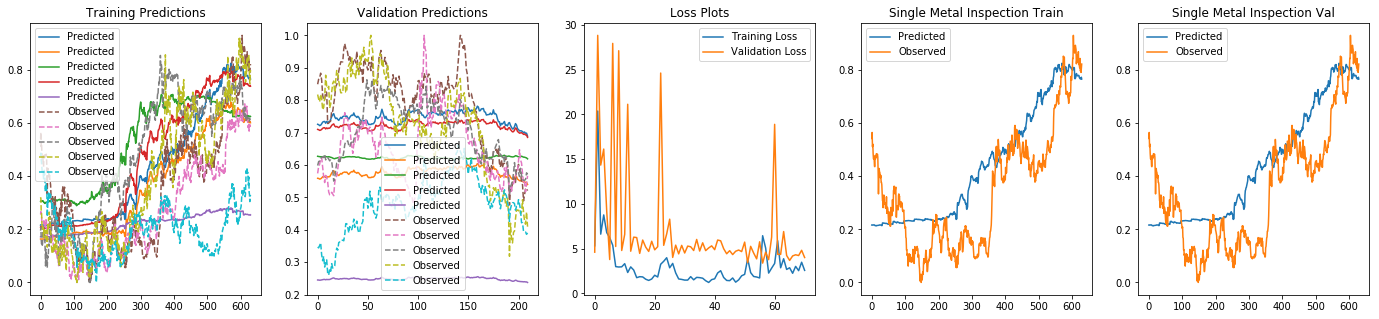

Epoch: 80 Train: 1.85989 Val: 3.35107  Time: 125.170  Best Val: 3.35107


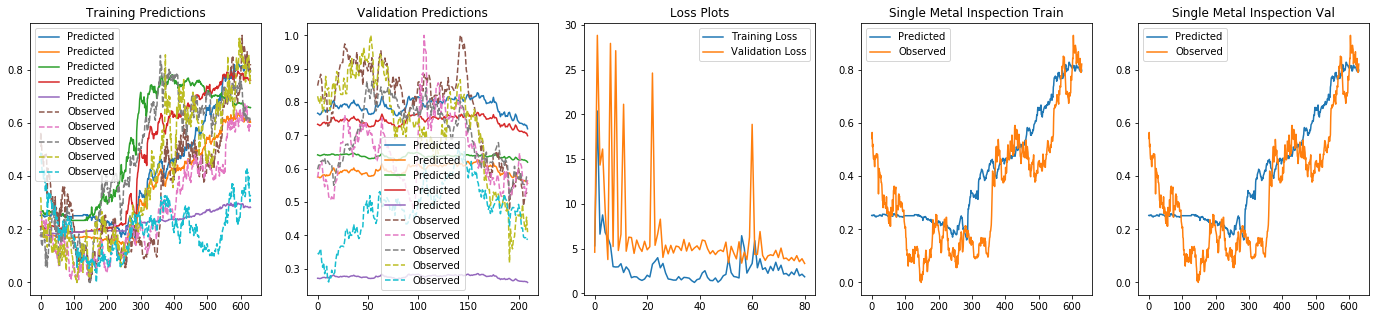

Epoch: 90 Train: 2.06892 Val: 3.26469  Time: 140.666  Best Val: 3.17155


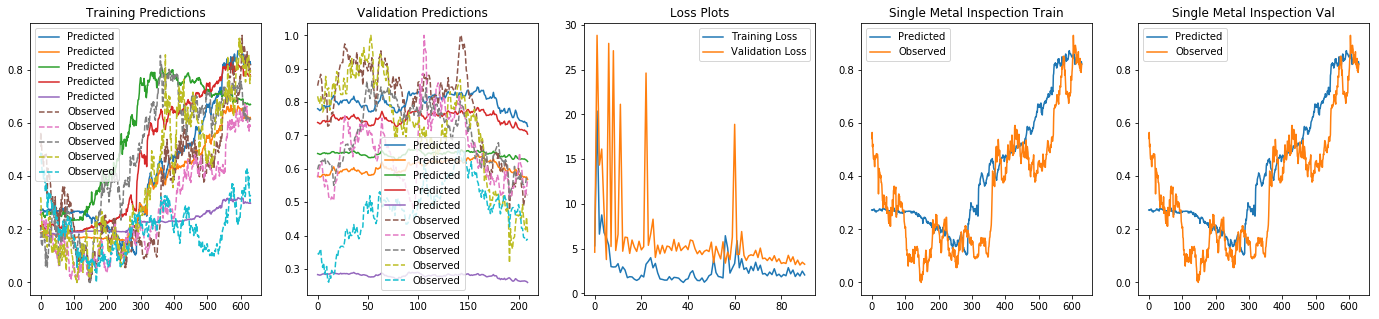

Epoch: 100 Train: 2.01506 Val: 3.21157  Time: 156.458  Best Val: 3.17155


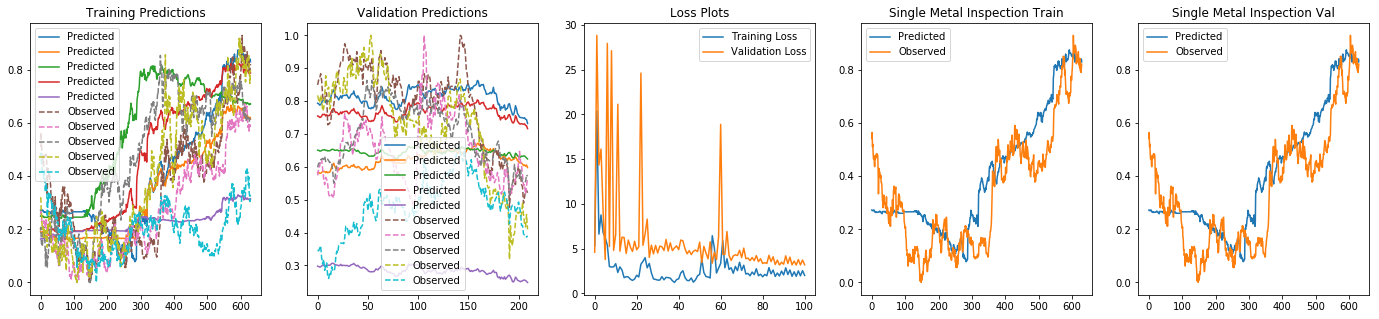

Epoch: 110 Train: 2.52167 Val: 14.15818  Time: 171.873  Best Val: 3.05938


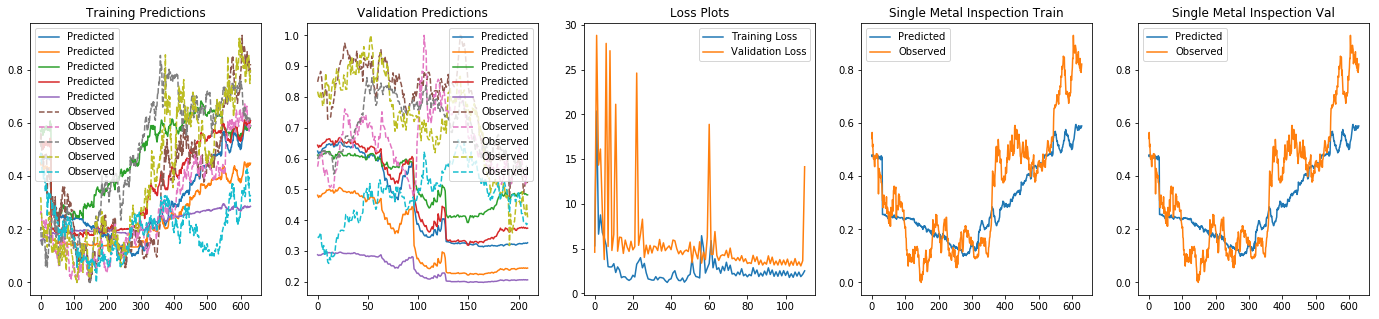

Epoch: 120 Train: 2.18276 Val: 2.84014  Time: 187.361  Best Val: 2.84014


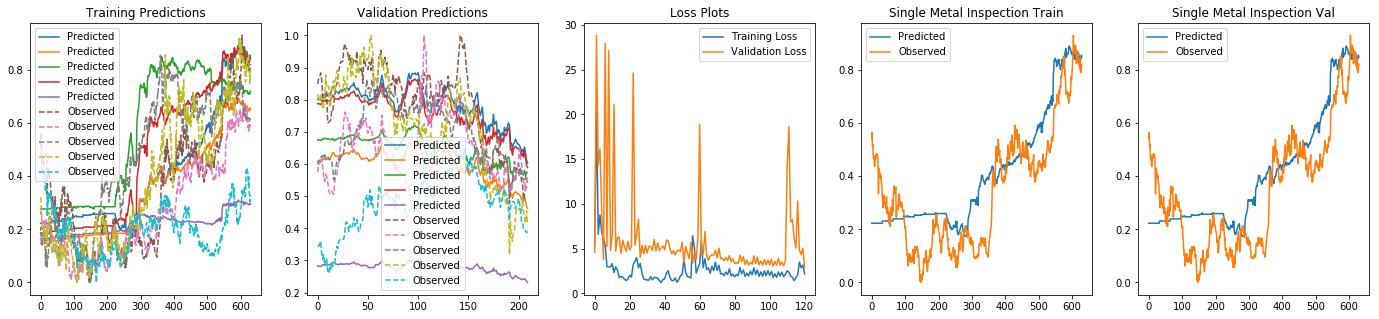

Epoch: 130 Train: 1.53002 Val: 2.61187  Time: 202.907  Best Val: 2.59680


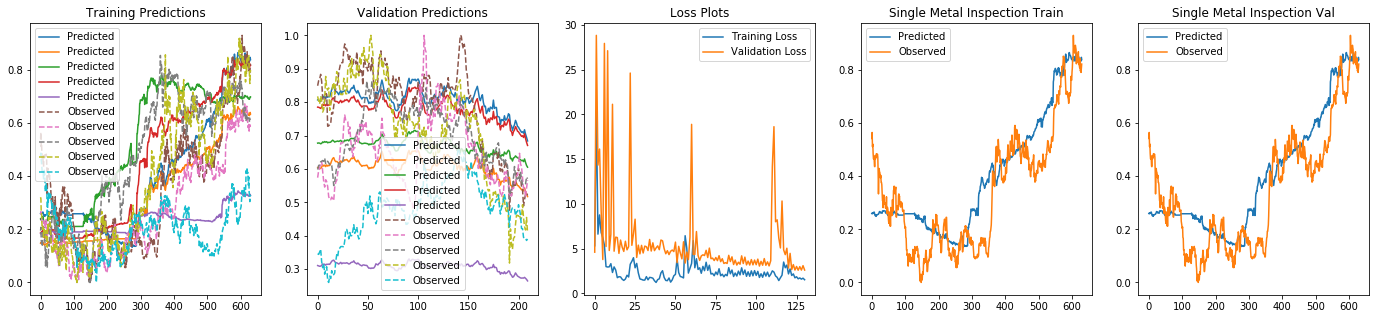

Epoch: 140 Train: 1.25957 Val: 2.63935  Time: 218.499  Best Val: 2.57311


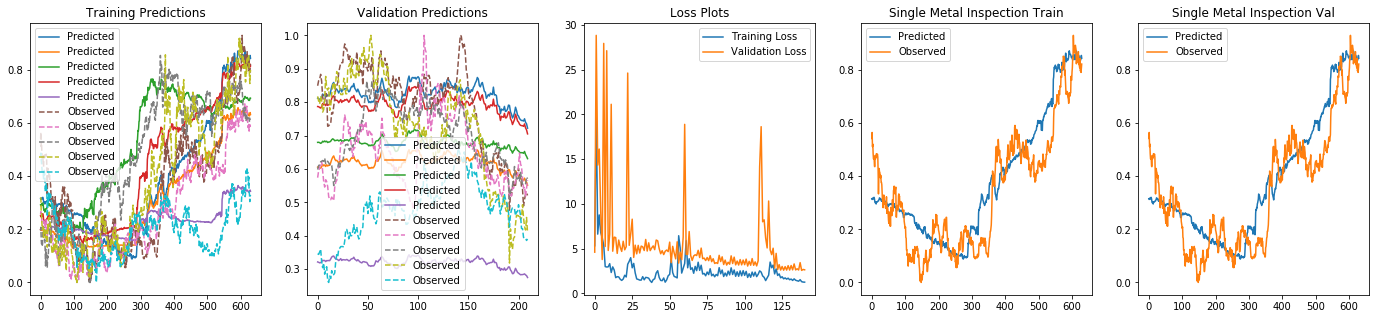

Epoch: 150 Train: 1.15011 Val: 2.60261  Time: 234.106  Best Val: 2.56640


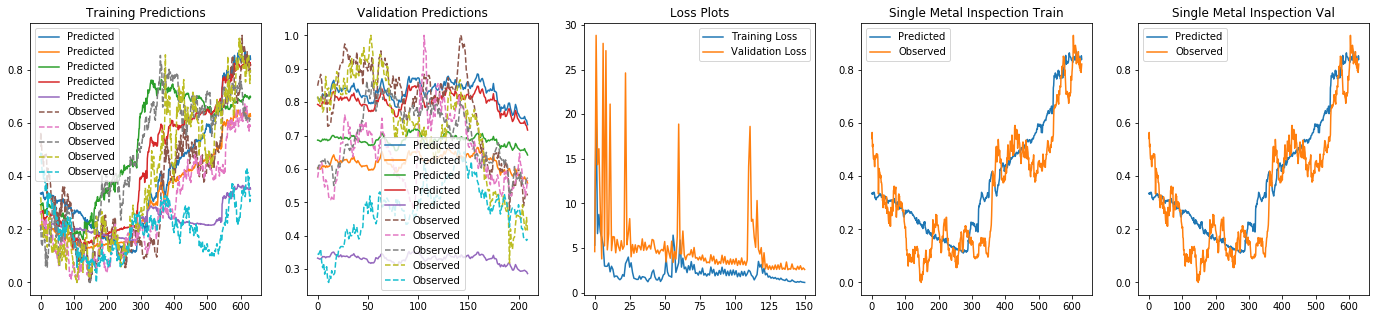

Epoch: 160 Train: 1.30368 Val: 2.69733  Time: 249.262  Best Val: 2.56640


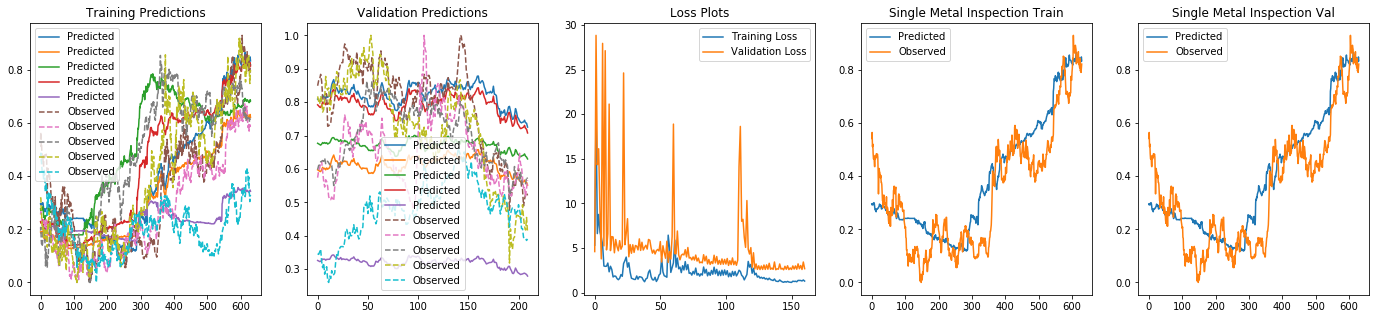

Epoch: 170 Train: 1.32427 Val: 2.71088  Time: 264.549  Best Val: 2.56640


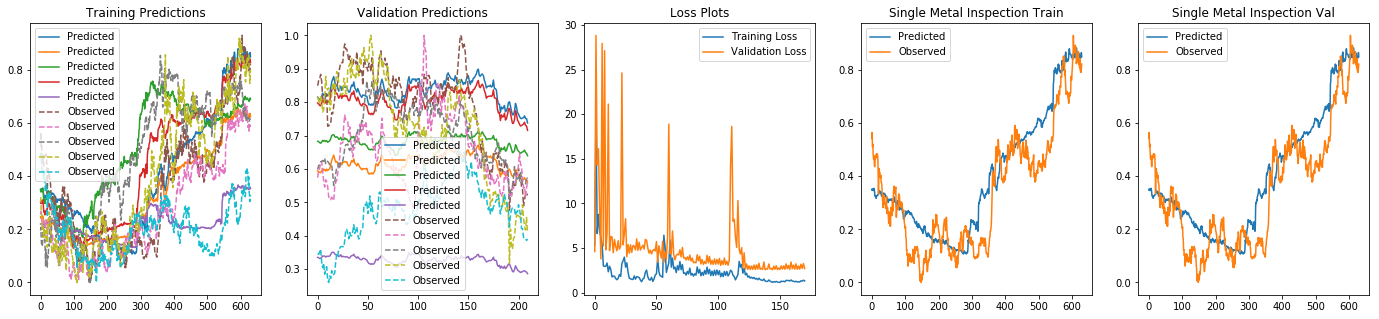

Epoch: 180 Train: 1.16183 Val: 2.63593  Time: 280.170  Best Val: 2.56640


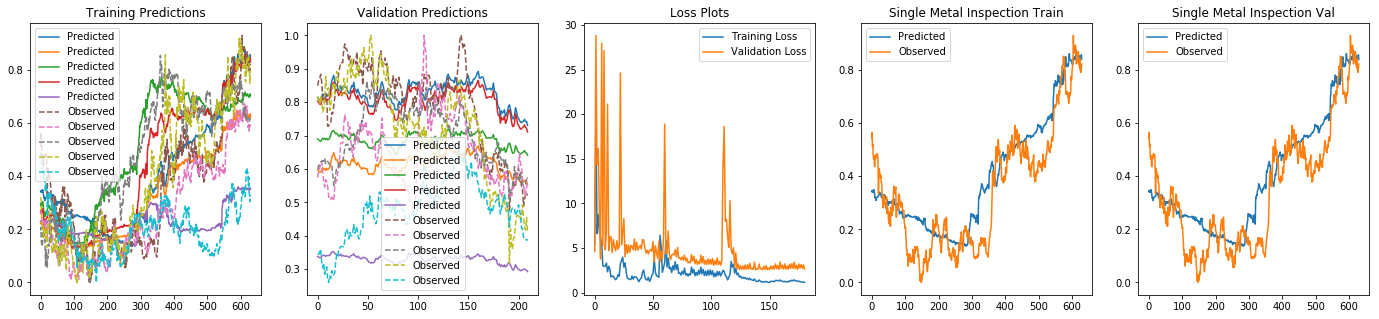

Epoch: 190 Train: 1.33252 Val: 2.50110  Time: 295.753  Best Val: 2.50110


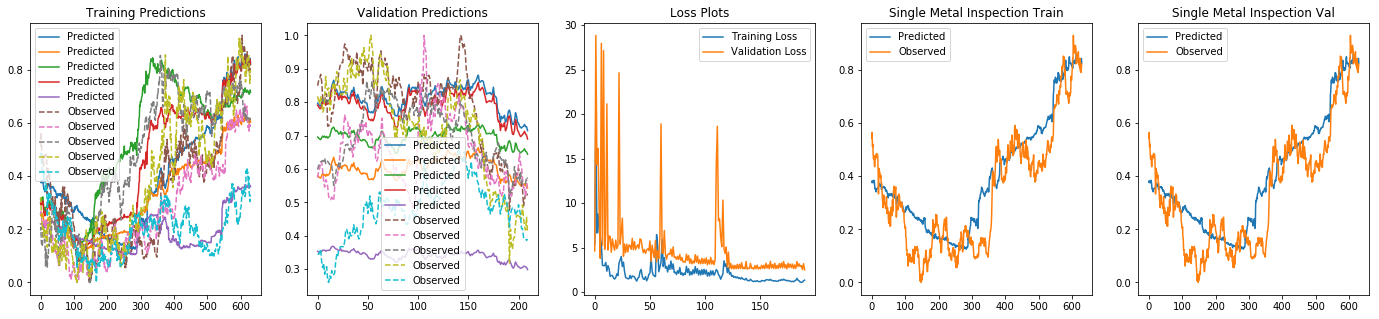

Epoch: 200 Train: 1.21728 Val: 2.80478  Time: 311.194  Best Val: 2.43196


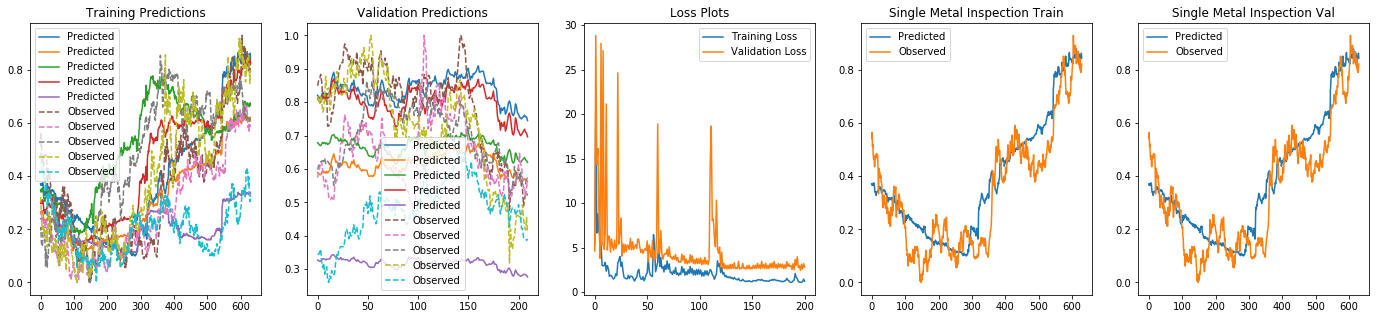

Epoch: 210 Train: 0.84241 Val: 2.82859  Time: 326.748  Best Val: 2.37341


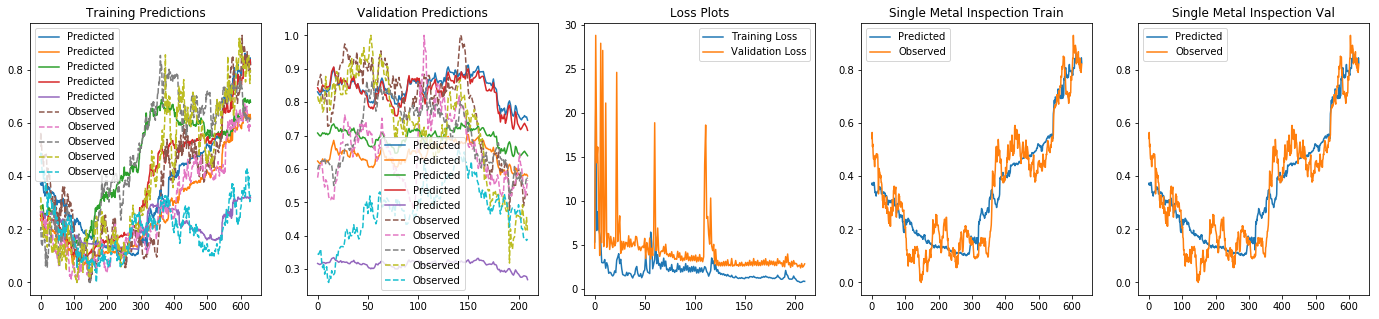

Epoch: 220 Train: 1.87871 Val: 2.53196  Time: 342.238  Best Val: 2.17917


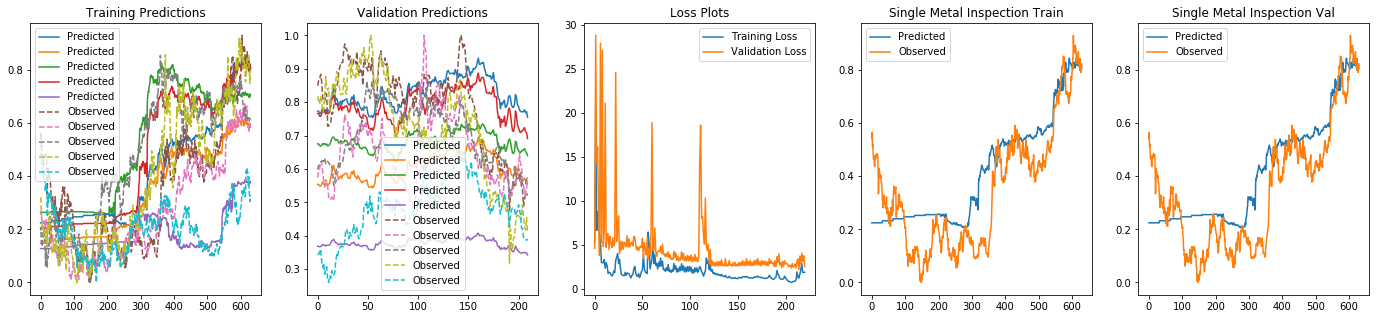

Epoch: 230 Train: 1.77094 Val: 3.39476  Time: 357.501  Best Val: 2.17917


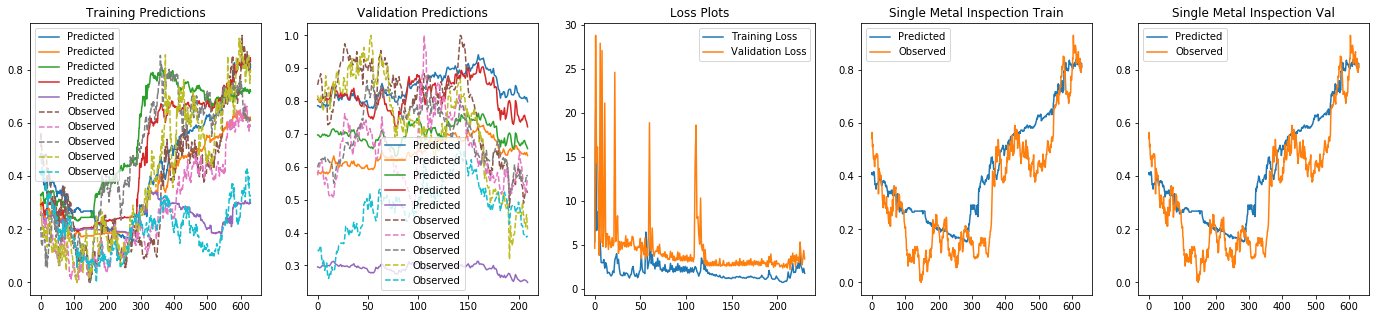

Epoch: 240 Train: 1.30961 Val: 3.32439  Time: 372.814  Best Val: 2.17917


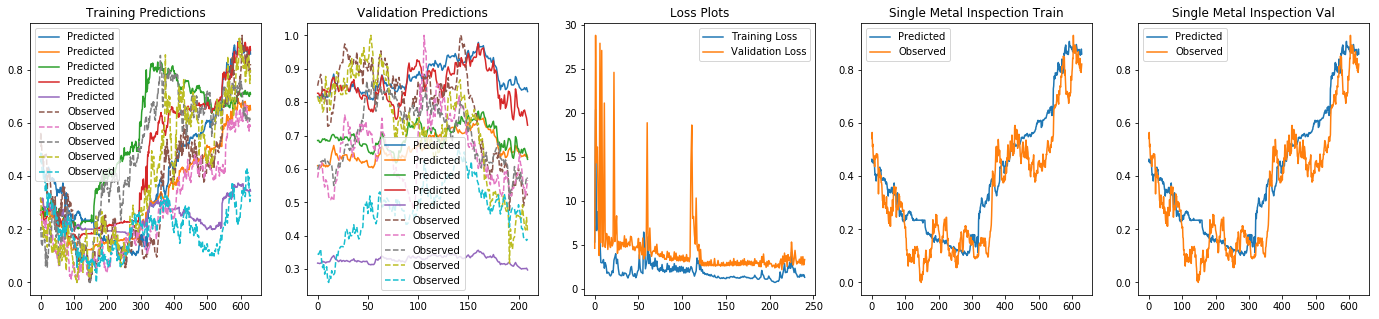

Epoch: 250 Train: 1.27841 Val: 3.32094  Time: 388.101  Best Val: 2.17917


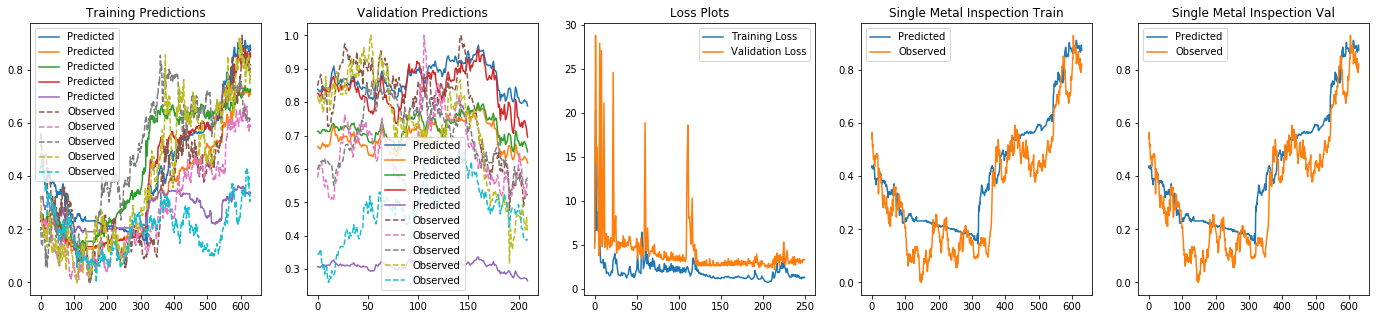

Epoch: 260 Train: 1.06439 Val: 3.18960  Time: 403.450  Best Val: 2.17917


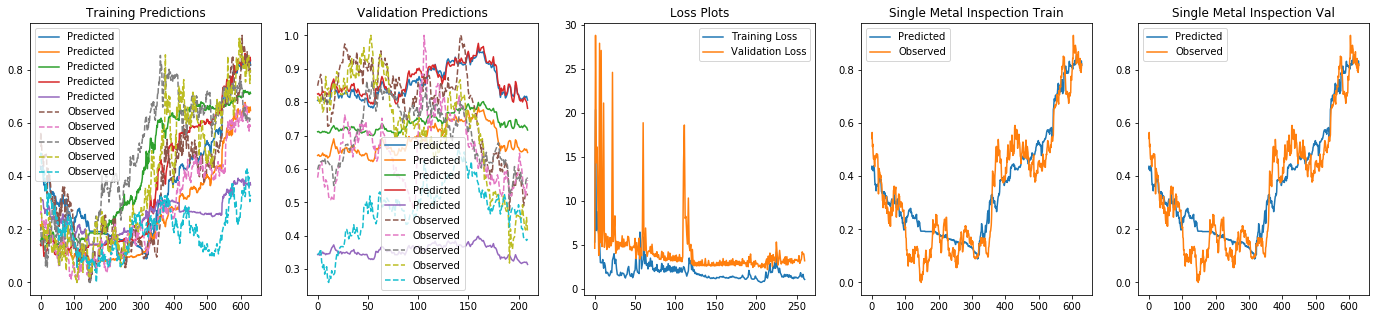

Epoch: 270 Train: 0.98482 Val: 3.27231  Time: 418.742  Best Val: 2.17917


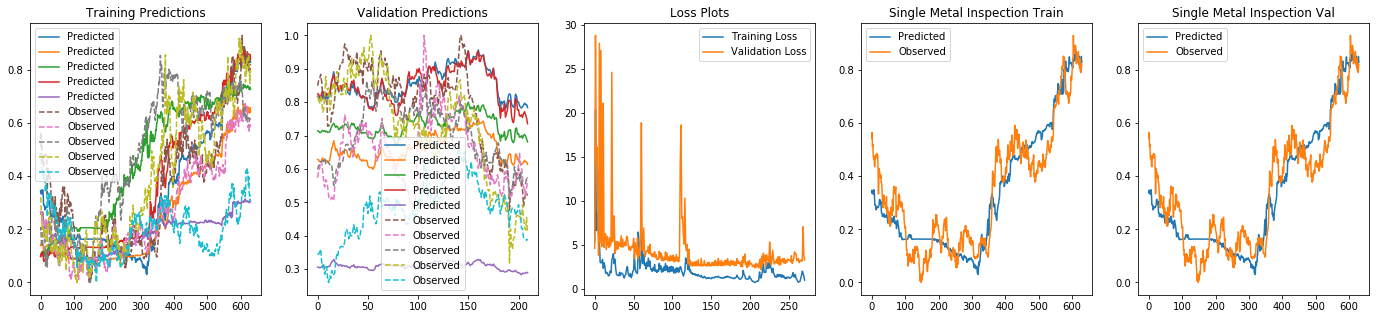

Early Stopping


In [148]:
optimiser = torch.optim.Adam(model.parameters(), learning_rate)

"""Do I need to declare a data explicitly in the dataset"""
learning = DeepLearning(model=model, 
                        data_X=data_X, 
                        data_y=data_y, 
                        n_epochs=n_epochs,
                        optimiser=optimiser,
                        batch_size=batch_size,
                        debug=False, 
                        disp_freq=disp_freq,
                        fig_disp_freq=fig_disp_freq, 
                        device=device,
                        patience=patience, 
                        scaler_data_X=scaler_data_X,
                        scaler_data_y=scaler_data_y)


# Splitting the data into the train, validation and test sets
learning.train_val_test()
learning.training_wrapper()

### Evaluating on Test Data

In [149]:
# learning.val_loader = learning.test_loader
learning.evaluate(learning.best_model, learning.test_loader)

4.292937382702579

### Saving Model Object

In [150]:
model_name = "MTL_Auto" + "_F" + str(forecast_length)
print(model_name)
pickle.dump(learning, open("Results/Pickles/" + model_name, 'wb'))
model_save(model, model_name)

MTL_Auto_F132
Saving model: Models/MTL_Auto_F132.pth


### Loading Example

In [151]:
# learning = pickle.load(open("Results/Pickles/" + "Learning_Univariate_SS_H4_5_", 'rb'))
# model = model_load(path="Results/Pths/",
#            model_name="Univariate_SS_H4_5_")

### Rescaling & Plotting

In [152]:
# Observed
train_true = learning.scaler_data_y.inverse_transform(learning.y_train.numpy())
val_true  = learning.scaler_data_y.inverse_transform(learning.y_val.numpy())
test_true  = learning.scaler_data_y.inverse_transform(learning.y_test.numpy())

# Predicted
train_pred = learning.scaler_data_y.inverse_transform(np.array(learning.train_predictions))
val_pred  = learning.scaler_data_y.inverse_transform(np.array(learning.val_predictions))
test_pred = learning.scaler_data_y.inverse_transform(np.array(learning.test_predictions))

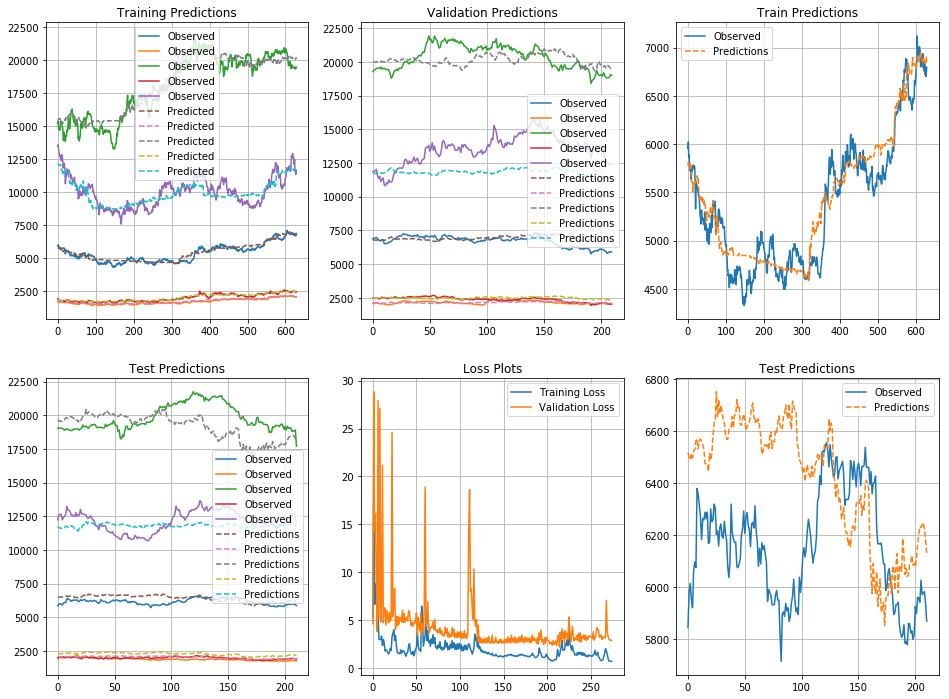

In [153]:
# Rescaling Example
fig, ax = plt.subplots(2, 3, figsize=(16, 12))

ax[0, 0].set_title("Training Predictions")
ax[0, 0].plot(train_true, label="Observed")
ax[0, 0].plot(train_pred, '--', label="Predicted")
ax[0, 0].grid()
ax[0, 0].legend()

ax[0, 1].grid()
ax[0, 1].set_title("Validation Predictions")
ax[0, 1].plot(val_true, label="Observed")
ax[0, 1].plot(val_pred, '--', label="Predictions")
ax[0, 1].legend()

ax[1, 0].grid()
ax[1, 0].set_title("Test Predictions")
ax[1, 0].plot(test_true, label="Observed")
ax[1, 0].plot(test_pred, '--', label="Predictions")
ax[1, 0].legend()

ax[1, 1].grid()
ax[1, 1].set_title("Loss Plots")
ax[1, 1].plot(learning.logs['Training Loss'], label="Training Loss")
ax[1, 1].plot(learning.logs['Validation Loss'], label="Validation Loss")
ax[1, 1].legend()

ax[0, 2].grid()
ax[0, 2].set_title("Train Predictions")
ax[0, 2].plot(train_true[:, 0], label="Observed")
ax[0, 2].plot(train_pred[:, 0], '--', label="Predictions")
ax[0, 2].legend()


ax[1, 2].grid()
ax[1, 2].set_title("Test Predictions")
ax[1, 2].plot(test_true[:, 0], label="Observed")
ax[1, 2].plot(test_pred[:, 0], '--', label="Predictions")
ax[1, 2].legend()

path = "Results/Plots/"
plt.savefig(path + model_name + ".png")
plt.show()

### Evaluating Results

In [154]:
mse, mae, mde = evaluate(test_pred, test_true, log_ret=False)
print("Price Metrics: ", 
      mse, mae, mde)

Price Metrics:  624566.2462084554 549.0553136482341 0.4657142857142857


### Naive Example

In [155]:
test_naive = test_true[forecast_length:, :]
mse_naive, mae_naive, mde_naive = evaluate(test_naive, test_true[:-forecast_length], log_ret=False)
print("Naive: ", mse_naive, mae_naive, mde_naive)

Naive:  472442.6 411.0791 0.4153846153846154


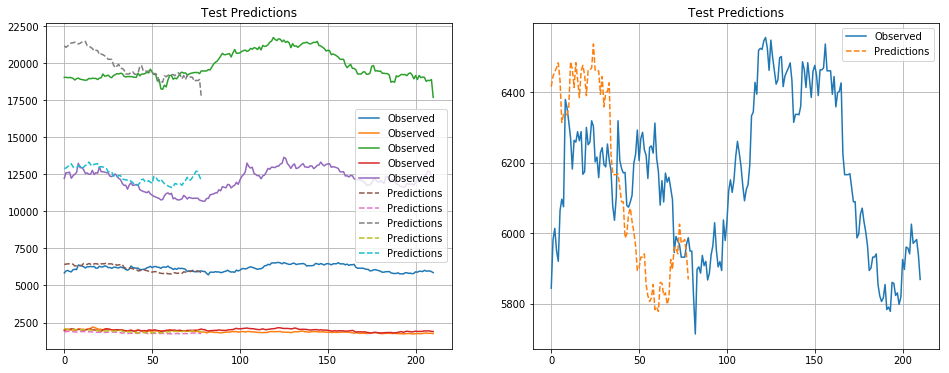

In [156]:
# Rescaling Example
fig, ax = plt.subplots(1, 2, figsize=(16, 6))


ax[0].grid()
ax[0].set_title("Test Predictions")
ax[0].plot(test_true, label="Observed")
ax[0].plot(test_naive, '--', label="Predictions")
ax[0].legend()


ax[1].grid()
ax[1].set_title("Test Predictions")
ax[1].plot(test_true[:,0][:], label="Observed")
ax[1].plot(test_naive[:,0], '--', label="Predictions")
ax[1].legend()

path = "Results/Plots/"
plt.savefig(path + "MTL_Naive_F" + str(forecast_length) + ".png")
plt.show()